[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/VaasuDevanS/kaggle-submissions/blob/main/Notebooks/01-nlp-with-disaster-tweets.ipynb)

<h1>Natural Language Processing with Disaster Tweets</h1>

[https://www.kaggle.com/c/nlp-getting-started](https://www.kaggle.com/c/nlp-getting-started)

Author: Vaasudevan Srinivasan [(Portfolio)](https://vaasudevans.github.io) <br>
Created on: July 06, 2021 <br>




# Download and unzip the Dataset

In [ ]:
%%capture
%%bash

pip install --upgrade --force-reinstall --no-deps kaggle
mkdir ~/.kaggle 
cp kaggle.json ~/.kaggle/
chmod 600 /root/.kaggle/kaggle.json
kaggle competitions download -c nlp-getting-started
unzip -o nlp-getting-started -d data

# Import all the Modules

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow as tf
import pandas as pd
import numpy as np

tf.__version__

'2.5.0'

# Read and Visualize

In [ ]:
train_df = pd.read_csv('data/train.csv')
train_df = train_df.sample(frac=1, random_state=42)
train_df.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


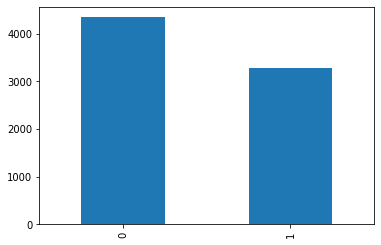

In [ ]:
train_df.target.value_counts().plot.bar();

In [ ]:
# Keep 10% for validation

x_train, x_val, y_train, y_val = train_test_split(train_df['text'].to_numpy(),
                                                  train_df['target'].to_numpy(),
                                                  test_size=0.1,
                                                  random_state=42)
print(x_train.shape, x_val.shape)

(6851,) (762,)


# Tokenization and Embedding

In [ ]:
# Average number of words in each tweet
np.mean([len(i.split()) for i in x_train])

14.901036345059115

In [ ]:
max_vocab_length = 10_000
max_length = 15  # Average words in each tweet

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

text_vectorizer.adapt(x_train)

In [ ]:
words_in_vocab = text_vectorizer.get_vocabulary()
print(words_in_vocab[:5])   # Most common words
print(words_in_vocab[-5:])  # Least common words

['', '[UNK]', 'the', 'a', 'in']
['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


# Transfer Learning

In [ ]:
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE')
model = tf.keras.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
h = model.fit(x=x_train,
              y=y_train,
              validation_data=(x_val, y_val),
              epochs=5)

Epoch 1/5
215/215 [==============================] - 7s 12ms/step - loss: 0.5059 - accuracy: 0.7869 - val_loss: 0.4493 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.4147 - accuracy: 0.8187 - val_loss: 0.4373 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3999 - accuracy: 0.8240 - val_loss: 0.4335 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3925 - accuracy: 0.8263 - val_loss: 0.4265 - val_accuracy: 0.8163
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3851 - accuracy: 0.8305 - val_loss: 0.4283 - val_accuracy: 0.8150


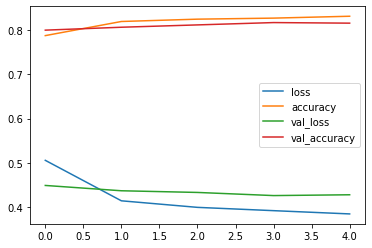

In [ ]:
pd.DataFrame(h.history).plot();

# Prediction and Submission

In [ ]:
test_df = pd.read_csv('data/test.csv')
x_test = test_df['text'].to_numpy()
print(x_test.shape)

(3263,)


In [ ]:
pred = model.predict(x_test)
pred = tf.squeeze(tf.round(pred)).numpy()
print(pred.shape)
print(pred[:10])

(3263,)
[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]


In [ ]:
test_df['target'] = pred.astype('uint8')
test_df.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1


In [ ]:
test_df[['id', 'target']].to_csv('submission.csv', index=False)

In [ ]:
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Transfer Learning using Universal Sentence Encoder"

100% 22.2k/22.2k [00:00<00:00, 76.7kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets